# Knowledge Extraction from a Convolutional Neural Network

Train a convolutional neural network to classify images and a CycleGAN to translate between images of different types.

This notebook contains everything to train a VGG network on labelled images and to train a CycleGAN to translate between images.

We will use electron microscopy images of Drosophila synapses for this project. Those images can be classified according to the neurotransmitter type they release.

### Project Ideas

1. Improve the classifier. This code uses a VGG network for the classification. On the synapse dataset, we will get a validation accuracy of around 80%. Try to see if you can improve the classifier accuracy.
    * (easy) Data augmentation: The training code for the classifier is quite simple in this example. Enlarge the amount of available training data by adding augmentations (transpose and mirror the images, add noise, change the intensity, etc.).
    * (easy) Network architecture: The VGG network has a few parameters that one can tune. Try a few to see what difference it makes.
    * (easy) Inspect the classifier predictions: Take random samples from the test dataset and classify them. Show the images together with their predicted and actual labels.
    * (medium) Other networks:  Try different architectures (e.g., a ResNet) and see if the accuracy can be improved.
    * (medium) Inspect errors made by the classifier. Which classes are most accurately predicted? Which classes are confused with each other?
    
    
2. Explore the CycleGAN.
    * (easy) The example code below shows how to translate between GABA and glutamate. Try different combinations, and also in the reverse direction. Can you start to see differences between some pairs of classes? Which are the ones where the differences are the most or the least obvious?
    * (hard) Watching the CycleGAN train can be a bit boring. Find a way to show (periodically) the current image and its translation to see how the network is improving over time. Hint: The `cycle_gan` module has a `Visualizer`, which might be helpful.
    

3. Try on your own data!
    * Have a look at how the synapse images are organized in `data/raw/synapses`. Copy the directory structure and use your own images. Depending on your data, you might have to adjust the image size (128x128 for the synapses) and number of channels in the VGG network and CycleGAN code.

### Acknowledgments

This notebook was written by Jan Funke, using code from Nils Eckstein and a modified version of the [CycleGAN](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) implementation.


# Section 1: Train an Image Classifier

In this section, we will implement and train a VGG classifier to classify images of synapses into one of six classes, corresponding to the neurotransmitter type that is released at the synapse: GABA, acethylcholine, glutamate, octopamine, serotonin, and dopamine.

## Data Preparation

In [ ]:
# Download the resources for this tutorial (one zip file)
!wget 'https://www.dropbox.com/sh/ucpjfd3omjieu80/AAAvZynLtzvhyFx7_jwVhUK2a?dl=0&preview=data.zip' -O resources.zip

In [ ]:
# Unzip the 'synapses' dataset and model checkpoints
# (this will take a while)
!unzip -o resources.zip data.zip
!unzip -o resources.zip checkpoints.zip
!unzip -o data.zip 'data/raw/synapses/*'
!unzip -o checkpoints.zip 'checkpoints/synapses/*'
# make sure the order of classes matches the pretrained model
!mv data/raw/synapses/gaba data/raw/synapses/0_gaba      
!mv data/raw/synapses/acetylcholine data/raw/synapses/1_acetylcholine
!mv data/raw/synapses/glutamate data/raw/synapses/2_glutamate 
!mv data/raw/synapses/serotonin data/raw/synapses/3_serotonin 
!mv data/raw/synapses/octopamine data/raw/synapses/4_octopamine 
!mv data/raw/synapses/dopamine data/raw/synapses/5_dopamine 

## Classifier Training

### Create and Inspect Datasets

First, we create a `torch` data loaders for training, validation, and testing. We will use weighted sampling to account for the class imbalance during training.

In [ ]:
from skimage.io import imread
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
import torch
import numpy as np

def load_image(filename):
    
    image = imread(filename)
    
    # images are grescale, we only need one of the RGB channels 
    image = image[:, :, 0]
    
    # img is uint8 in [0, 255], but we want float32 in [-1, 1]
    image = image.astype(np.float32)/255.0
    image = (image - 0.5)/0.5
    
    return image

# create a dataset for all images of all classes
full_dataset = ImageFolder(root='data/raw/synapses', loader=load_image)

# randomly split the dataset into train, validation, and test
num_images = len(full_dataset)
# ~70% for training
num_training = int(0.7 * num_images)
# ~15% for validation
num_validation = int(0.15 * num_images)
# ~15% for testing
num_test = num_images - (num_training + num_validation)
# split the data randomly (but with a fixed random seed)
train_dataset, validation_dataset, test_dataset = random_split(
    full_dataset,
    [num_training, num_validation, num_test],
    generator=torch.Generator().manual_seed(23061912))

# compute class weights in training dataset for uniform sampling
ys = np.array([y for _, y in train_dataset])
counts = np.bincount(ys)
label_weights = 1.0 / counts
weights = label_weights[ys]

print("Number of images per class:")
for c, n, w in zip(full_dataset.classes, counts, label_weights):
    print(f"\t{c}:\tn={n}\tweight={w}")

# create a data loader with uniform sampling
sampler = WeightedRandomSampler(weights, len(weights))
# this data loader will serve 8 images in a "mini-batch" at a time
dataloader = DataLoader(train_dataset, batch_size=8, drop_last=True, sampler=sampler)

Number of images per class:
	0_gaba:	n=15855	weight=6.30715862503942e-05
	1_acetylcholine:	n=4911	weight=0.00020362451639177357
	2_glutamate:	n=3550	weight=0.00028169014084507044
	3_serotonin:	n=2297	weight=0.00043535045711797995
	4_octopamine:	n=951	weight=0.0010515247108307045
	5_dopamine:	n=4649	weight=0.00021510002151000216


The cell below visualizes a single, randomly chosen batch from the training data loader. Feel free to execute this cell multiple times to get a feeling for the dataset. See if you can tell the difference between synapses of different types!

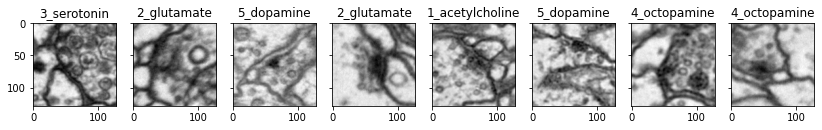

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

def show_batch(x, y):
    fig, axs = plt.subplots(1, x.shape[0], figsize=(14, 14), sharey=True)
    for i in range(x.shape[0]):
        axs[i].imshow(np.squeeze(x[i]), cmap='gray')
        axs[i].set_title(train_dataset.dataset.classes[y[i].item()])
    plt.show()

# show a random batch from the data loader
# (run this cell repeatedly to see different batches)
for x, y in dataloader:
    show_batch(x, y)
    break

### Create a Model, Loss, and Optimizer

In [ ]:
class Vgg2D(torch.nn.Module):

    def __init__(
            self,
            input_size,
            fmaps=12,
            downsample_factors=[(2, 2), (2, 2), (2, 2), (2, 2)],
            output_classes=6):

        super(Vgg2D, self).__init__()

        self.input_size = input_size

        current_fmaps = 1
        current_size = tuple(input_size)

        features = []
        for i in range(len(downsample_factors)):

            features += [
                torch.nn.Conv2d(
                    current_fmaps,
                    fmaps,
                    kernel_size=3,
                    padding=1),
                torch.nn.BatchNorm2d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(
                    fmaps,
                    fmaps,
                    kernel_size=3,
                    padding=1),
                torch.nn.BatchNorm2d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool2d(downsample_factors[i])
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c/d)
                for c, d in zip(current_size, downsample_factors[i]))
            check = (
                s*d == c
                for s, d, c in zip(size, downsample_factors[i], current_size))
            assert all(check), \
                "Can not downsample %s by chosen downsample factor" % \
                (current_size,)
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(
                current_size[0] *
                current_size[1] *
                current_fmaps,
                4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(
                4096,
                4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(
                4096,
                output_classes)
        ]

        self.classifier = torch.nn.Sequential(*classifier)
    
    def forward(self, raw):

        # add a channel dimension to raw
        shape = tuple(raw.shape)
        raw = raw.reshape(shape[0], 1, shape[1], shape[2])
        
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)
        
        # classify
        y = self.classifier(f)

        return y

In [ ]:
# get the size of our images
for x, y in train_dataset:
    input_size = x.shape
    break

# create the model to train
model = Vgg2D(input_size)

# create a loss
loss = torch.nn.CrossEntropyLoss()

# create an optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Train the Model

In [ ]:
# use a GPU, if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Will use device {device} for training")

Will use device cuda for training


The next cell merely defines some convenience functions for training, validation, and testing:

In [ ]:
from tqdm import tqdm

def train():
    '''Train the model for one epoch.'''

    # set the model into train mode
    model.train()

    epoch_loss = 0

    num_batches = 0
    for x, y in tqdm(dataloader, 'train'):

        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()

        optimizer.step()

        epoch_loss += l
        num_batches += 1

    return epoch_loss/num_batches

def evaluate(dataloader, name):
    
    correct = 0
    total = 0
    for x, y in tqdm(dataloader, name):
        
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        probs = torch.nn.Softmax(dim=1)(logits)
        predictions = torch.argmax(probs, dim=1)
        
        correct += int(torch.sum(predictions == y).cpu().detach().numpy())
        total += len(y)
    
    accuracy = correct/total

    return accuracy

def validate():
    '''Evaluate prediction accuracy on the validation dataset.'''
    
    model.eval()
    dataloader = DataLoader(validation_dataset, batch_size=32)
   
    return evaluate(dataloader, 'validate')

def test():
    '''Evaluate prediction accuracy on the test dataset.'''
    
    model.eval()
    dataloader = DataLoader(test_dataset, batch_size=32)
    
    return evaluate(dataloader, 'test')

We are ready to train. After each epoch (roughly going through each training image once), we report the training loss and the validation accuracy.

In [ ]:
for epoch in range(100):
    
    epoch_loss = train()
    print(f"epoch {epoch}, training loss={epoch_loss}")
    
    accuracy = validate()
    print(f"epoch {epoch}, validation accuracy={accuracy}")

Feel free to watch your model train... 
![model_train.jpeg](attachment:model_train.jpeg)

Or interrupt the current cell and run the next one, which will load a checkpoint that we already prepared.

In [ ]:
# SHORTCUT (OPTIONAL): load a pretrained model

# change this to True and run this cell if you want a shortcut
yes_I_want_the_pretrained_model = False

if yes_I_want_the_pretrained_model:
    checkpoint = torch.load('checkpoints/synapses/classifier/vgg_checkpoint', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
accuracy = test()
print(f"final test accuracy: {accuracy}")

test: 100%|█████████████████████████████████████████████████████████████| 216/216 [00:14<00:00, 14.96it/s]

final test accuracy: 0.8054750869061413


This concludes the first section. We now have a classifier that can discriminate between images of different types.

If you used the images we provided, the classifier is not perfect (you should get an accuracy of around 80%), but pretty good considering that there are six different types of images. Furthermore, it is not so clear for humans how the classifier does it. Feel free to explore the data a bit more and see for yourself if you can tell the difference betwee, say, GABAergic and glutamatergic synapses.

So this is an interesting situation: The VGG network knows something we don't quite know. In the next section, we will see how we can visualize the relevant differences between images of different types.

# Section 2: Train a GAN to Translate Images

We will train a so-called CycleGAN to translate images from one class to another.

In [ ]:
# get the CycleGAN code and dependencies
!git clone https://github.com/funkey/neuromatch_xai
!mv neuromatch_xai/cycle_gan .
!pip install dominate

In this example, we will translate between GABAergic and glutamatergic synapses.

First, we have to copy images of either type into a format that the CycleGAN library is happy with. Afterwards, we can start training on those images.

In [ ]:
import cycle_gan
cycle_gan.prepare_dataset('data/raw/synapses/', ['0_gaba', '2_glutamate'])
cycle_gan.train('data/raw/synapses/', '0_gaba', '2_glutamate', 128)

...this time again.
![model_train_2.jpeg](attachment:model_train_2.jpeg)

Training the CycleGAN takes a lot longer than the VGG we trained above (on the synapse dataset, this will be around 7 days...).

To continue, interrupt the kernel and continue with the next one, which will just use one of the pretrained CycleGAN models for the synapse dataset.

In [ ]:
# translate images from class A to B, and classify each with the VGG network trained above
cycle_gan.test(
    data_dir='data/raw/synapses/',
    class_A='0_gaba',
    class_B='2_glutamate',
    img_size=128,
    checkpoints_dir='checkpoints/synapses/cycle_gan/gaba_glutamate/',
    vgg_checkpoint='checkpoints/synapses/classifier/vgg_checkpoint'
)

Read all translated images and sort them by how much the translation "fools" the VGG classifier trained above:

In [ ]:
import glob
import json

class_A_index = 0
class_B_index = 2

result_dir = 'data/raw/synapses/cycle_gan/0_gaba_2_glutamate/results/test_latest/images/'
classification_results = []
for f in glob.glob(result_dir + '/*.json'):
    result = json.load(open(f))
    result['basename'] = f.replace('_aux.json', '')
    classification_results.append(result)
classification_results.sort(
    key=lambda c: c['aux_real'][class_A_index] * c['aux_fake'][class_B_index],
    reverse=True)

Show the top real and fake images that make the classifier change its mind:

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread

def show_pair(a, b, score_a, score_b, class_a, class_b):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20), sharey=True)
    axs[0].imshow(a, cmap='gray')
    axs[0].set_title(f"p({class_a}) = " + str(score_a))
    axs[1].imshow(b, cmap='gray')
    axs[1].set_title(f"p({class_b}) = " + str(score_b))
    plt.show()

# show the top successful translations (according to our VGG classifier)
for i in range(10):
    basename = classification_results[i]['basename']
    score_A = classification_results[i]['aux_real'][class_A_index]
    score_B = classification_results[i]['aux_fake'][class_B_index]
    real_A = imread(basename + '_real.png')
    fake_B = imread(basename + '_fake.png')
    show_pair(real_A, fake_B, score_A, score_B, 'gaba', 'glutamate')